In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import json
import pickle

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 32
AVAIL_GPUS = min(1,torch.cuda.device_count())
NUM_WORKERS = 1

In [2]:
os.mkdir("Results")

In [3]:
p = 32

In [4]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir = "Landscape", transform=None,img_size=(256, 256),wp = 3,hp = 3,split=None):
        super(CustomDataset).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(self.root_dir)
        self.img_size = img_size
        self.wp = wp
        self.hp = hp
        random.seed(random_seed)
        random.shuffle(self.image_files)

        if split is not None:
            train_ratio=0.8
            val_ratio=0.1
            random.shuffle(self.image_files)

            if split=='train':
                self.image_files = self.image_files[:int(len(self.image_files)*train_ratio)]
            elif split=='val':
                self.image_files = self.image_files[int(len(self.image_files) * train_ratio):int(len(self.image_files)*(train_ratio+val_ratio))]
            elif split=='test':
                self.image_files = self.image_files[int(len(self.image_files)*(train_ratio+val_ratio)):]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB').resize(self.img_size)
        
        mask_size = (p,p)
        x = 128
        y = 128
        mask_box = (x-p//2,y-p//2, x+ p//2,y + p//2)

        

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)
        
        masked_image = image.clone()
        masked_image[:,x-p//2:x+p//2,y-p//2:y + p//2] = torch.zeros(size = (3,p,p))

        return image,masked_image 

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='train')
val_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='val')
test_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='test')

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)


In [5]:
for images,masked_images in train_dataloader:
    break
masked_images.shape

torch.Size([32, 3, 256, 256])

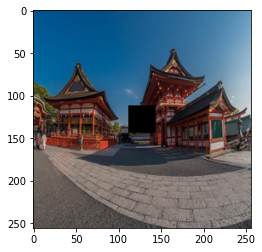

In [6]:
plt.imshow(masked_images[0].permute(1,2,0))

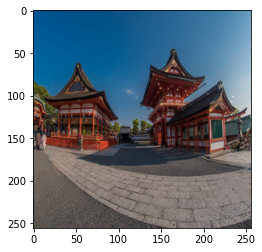

In [7]:
plt.imshow(images[0].permute(1,2,0))

In [11]:
USE_GPU = True
num_class = 12
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.encoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        self.bn3 = nn.BatchNorm2d(256)
        self.encoder4 = nn.Conv2d(256, 3, 3, 1, 1, bias=True)


    def forward(self, input):        
        encoded = F.relu(self.bn1(self.encoder1(input)))
        encoded = F.relu(self.bn2(self.encoder2(encoded)))
        encoded = F.relu(self.bn3(self.encoder3(encoded)))
        encoded = F.sigmoid(self.encoder4(encoded))
        return encoded


In [12]:
lr = 1e-5
beta1 = 0.5
generator = Generator().to(device)

reconstruction_loss = nn.MSELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

best_generator_loss = 10
best_generator_dict = generator.state_dict()

num_epochs = 20
train_loss = {}
val_loss = {}
for epoch in range(num_epochs):
    
    generator.train()
    for batch_idx, (real_images, masked_images) in enumerate(train_dataloader):
        glosses = []  
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        generator.zero_grad()
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        g_loss.backward()
        optimizer_g.step()
        
        glosses.append(g_loss.item())

        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Generator Loss: {np.mean(glosses):.4f}")
            
            train_loss[(epoch+1),(batch_idx+1)] = np.mean(glosses)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
        f"Generator Loss: {np.mean(glosses):.4f}")
    
    train_loss[(epoch+1),(batch_idx+1)] = np.mean(glosses)
    
    generator.eval()
    val_glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(val_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        val_glosses.append(g_loss.item())
    
    mean_g_loss = np.mean(val_glosses)
    print("mean_generator_val_loss: ",np.mean(mean_g_loss))
    val_loss[epoch+1] = np.mean(mean_g_loss)
    
    if(mean_g_loss < best_generator_loss):
        best_generator_loss = mean_g_loss
        best_generator_dict = generator.state_dict()
        print("best")
        
    print(f"Epoch [{epoch+1}/{num_epochs}],"
        f"Val Generator Loss: {mean_g_loss:.4f}")

torch.save(best_generator_dict, 'Results/generator_weights.pth')

with open('Results/train.pickle', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Results/val.pickle', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
generator.load_state_dict(best_generator_dict)

for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
    break
masked_images = masked_images.to(device)
predict = generator(masked_images)

masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict

<All keys matched successfully>

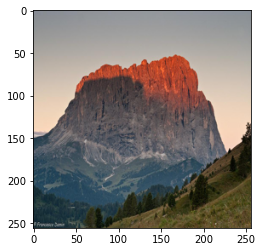

In [18]:
i = 6
plt.imshow(real_images[i].permute(1,2,0).cpu())

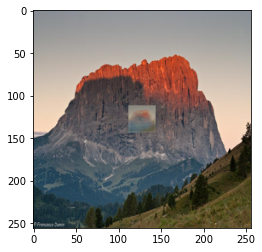

In [19]:
plt.imshow(masked_images[i].permute(1,2,0).cpu().detach().numpy())

In [20]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv_query = nn.Conv2d(in_channels,in_channels,(1,1))
        self.conv_key = nn.Conv2d(in_channels,in_channels,(1,1))
        self.conv_value = nn.Conv2d(in_channels,in_channels,(1,1))

    def forward(self, x):
        N, C, H, W = x.shape
        
        q = self.conv_query(x).reshape(N,C,H*W)
        k = self.conv_key(x).reshape(N,C,H*W)
        v = self.conv_value(x).reshape(N,C,H*W)
        attention_weights = torch.softmax(torch.matmul(q.transpose(1, 2), k), dim=-1)
        attention = torch.matmul(v, attention_weights.transpose(1, 2))
        attention = attention.reshape(N, C, H, W)
        return x + attention

class GeneratorWithAttention(nn.Module):
    def __init__(self):
        super(GeneratorWithAttention, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.encoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        self.attn = Attention(256)
        self.bn3 = nn.BatchNorm2d(256)
        self.encoder4 = nn.Conv2d(256, 3, 3, 1, 1, bias=True)


    def forward(self, input):        
        encoded = F.relu(self.bn1(self.encoder1(input)))
        encoded = F.relu(self.bn2(self.encoder2(encoded)))
        encoded = F.relu(self.bn3(self.attn(self.encoder3(encoded))))
        encoded = F.sigmoid(self.encoder4(encoded))
        return encoded


In [25]:
lr = 1e-5
beta1 = 0.5
generator = GeneratorWithAttention().to(device)

reconstruction_loss = nn.MSELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

best_generator_loss = 10
best_generator_dict = generator.state_dict()

train_loss = {}
val_loss = {}
num_epochs = 20
for epoch in range(num_epochs):
    glosses = []  
    generator.train()
    for batch_idx, (real_images, masked_images) in enumerate(train_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        generator.zero_grad()
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        g_loss.backward()
        optimizer_g.step()
        
        glosses.append(g_loss.item())
        train_loss[(epoch+1),(batch_idx+1)] = np.mean(glosses)
        
        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Generator Loss: {np.mean(glosses).item():.4f}")
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
        f"Generator Loss: {np.mean(glosses).item():.4f}")
    
    train_loss[(epoch+1),(batch_idx+1)] = np.mean(glosses)
    
    generator.eval()
    val_glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(val_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        val_glosses.append(g_loss.item())
    
    mean_g_loss = np.mean(val_glosses)

    val_loss[epoch+1] = np.mean(mean_g_loss)
    if(mean_g_loss < best_generator_loss):
        best_generator_loss = mean_g_loss
        best_generator_dict = generator.state_dict()
        print("best")
        
    print(f"Epoch [{epoch+1}/{num_epochs}],"
        f"Val Generator Loss: {mean_g_loss:.4f}")


torch.save(best_generator_dict, 'Results/generator_weights_with_attention.pth')

with open('Results/train_with_attention.pickle', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Results/val_with_attention.pickle', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch [1/20], Batch [20/98], Generator Loss: 0.0645
Epoch [1/20], Batch [40/98], Generator Loss: 0.0555
Epoch [1/20], Batch [60/98], Generator Loss: 0.0500
Epoch [1/20], Batch [80/98], Generator Loss: 0.0465
Epoch [1/20], Batch [98/98], Generator Loss: 0.0446
best
Epoch [1/20],Val Generator Loss: 0.0353
Epoch [2/20], Batch [20/98], Generator Loss: 0.0332
Epoch [2/20], Batch [40/98], Generator Loss: 0.0331
Epoch [2/20], Batch [60/98], Generator Loss: 0.0323
Epoch [2/20], Batch [80/98], Generator Loss: 0.0318
Epoch [2/20], Batch [98/98], Generator Loss: 0.0314
best
Epoch [2/20],Val Generator Loss: 0.0299
Epoch [3/20], Batch [20/98], Generator Loss: 0.0279
Epoch [3/20], Batch [40/98], Generator Loss: 0.0290
Epoch [3/20], Batch [60/98], Generator Loss: 0.0290
Epoch [3/20], Batch [80/98], Generator Loss: 0.0285
Epoch [3/20], Batch [98/98], Generator Loss: 0.0286
best
Epoch [3/20],Val Generator Loss: 0.0282
Epoch [4/20], Batch [20/98], Generator Loss: 0.0260
Epoch [4/20], Batch [40/98], Gene

In [28]:
generator.load_state_dict(best_generator_dict)

for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
    break
masked_images = masked_images.to(device)
predict = generator(masked_images)

masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict

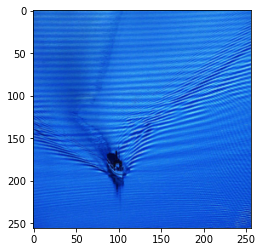

In [43]:
i = 10
plt.imshow(real_images[i].permute(1,2,0).cpu())

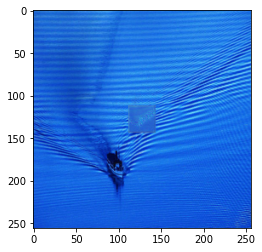

In [44]:
plt.imshow(masked_images[i].permute(1,2,0).cpu().detach().numpy())

In [54]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.decoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.decoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.decoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.decoder4 = nn.Conv2d(256, 1, 4, 2, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input):
        decoded = F.relu(self.bn1(self.decoder1(input)))
        decoded = F.relu(self.bn2(self.decoder2(decoded)))
        decoded = F.relu(self.bn3(self.decoder3(decoded)))
        decoded = self.sigmoid(self.decoder4(decoded))
        
        return decoded


In [55]:
lr = 5e-6
beta1 = 0.5
generator = GeneratorWithAttention().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


criterion = nn.BCELoss()
reconstruction_loss = nn.MSELoss()
num_epochs = 20
best_generator_loss = 10

train_loss = {}
val_loss = {}

for epoch in range(num_epochs):
    generator.train()
    dlosses = []
    glosses = []
    glosses1 = []
    glosses2 = []
    for batch_idx, (real_images, masked_images) in enumerate(train_dataloader):
        
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)

       
        discriminator.zero_grad()
        generator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        
        real_outputs = discriminator(real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]).reshape(batch_size,1)
        d_loss_real = criterion(real_outputs, real_labels)

        
        fake_images = generator(masked_images)
        fake_outputs = discriminator(fake_images.detach()).reshape(batch_size,1)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        fake_outputs = discriminator(fake_images).reshape(batch_size,1)
        g_loss1 = criterion(fake_outputs, real_labels)
        g_loss2 = reconstruction_loss(fake_images,real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2])
        g_loss = g_loss1 + 40*g_loss2
        g_loss.backward()
        optimizer_g.step()
        
        dlosses.append(d_loss.item())
        glosses.append(g_loss.item())
        glosses1.append(g_loss1.item())
        glosses2.append(g_loss2.item())

        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f},{np.mean(glosses1).item():.4f},{np.mean(glosses2).item():.4f}")
            train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses1),np.mean(glosses2))
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
        f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f}")
    train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses1),np.mean(glosses2))
    
    generator.eval()
    val_glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(val_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        val_glosses.append(g_loss.item())
    
    mean_g_loss = np.mean(val_glosses)

    val_loss[epoch+1] = np.mean(mean_g_loss)
    
    if(mean_g_loss < best_generator_loss):
        best_generator_loss = mean_g_loss
        best_generator_dict = generator.state_dict()
        print("best")
        
    print(f"Epoch [{epoch+1}/{num_epochs}],"
        f"Val Generator Loss: {mean_g_loss:.4f}")

torch.save(best_generator_dict, 'Results/generator_weights_with_gan_reconstruction_loss_attention.pth')

with open('Results/train_with_gan_reconstruction_loss_attention.pickle', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Results/val_with_gan_reconstruction_loss_attention.pickle', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch [1/20], Batch [20/98], Discriminator Loss: 1.3354, Generator Loss: 3.3430,0.6880,0.0664
Epoch [1/20], Batch [40/98], Discriminator Loss: 1.2500, Generator Loss: 3.2780,0.7795,0.0625
Epoch [1/20], Batch [60/98], Discriminator Loss: 1.2228, Generator Loss: 3.1300,0.8090,0.0580
Epoch [1/20], Batch [80/98], Discriminator Loss: 1.2196, Generator Loss: 2.9825,0.8201,0.0541
Epoch [1/20], Batch [98/98], Discriminator Loss: 1.2171, Generator Loss: 2.8831
best
Epoch [1/20],Val Generator Loss: 0.0360
Epoch [2/20], Batch [20/98], Discriminator Loss: 1.2040, Generator Loss: 2.2907,0.8651,0.0356
Epoch [2/20], Batch [40/98], Discriminator Loss: 1.2176, Generator Loss: 2.2629,0.8646,0.0350
Epoch [2/20], Batch [60/98], Discriminator Loss: 1.2203, Generator Loss: 2.2885,0.8653,0.0356
Epoch [2/20], Batch [80/98], Discriminator Loss: 1.2156, Generator Loss: 2.2830,0.8676,0.0354
Epoch [2/20], Batch [98/98], Discriminator Loss: 1.2117, Generator Loss: 2.2635
best
Epoch [2/20],Val Generator Loss: 0.033

Epoch [19/20], Batch [20/98], Discriminator Loss: 1.0680, Generator Loss: 2.4305,0.9507,0.0370
Epoch [19/20], Batch [40/98], Discriminator Loss: 1.0545, Generator Loss: 2.3829,0.9579,0.0356
Epoch [19/20], Batch [60/98], Discriminator Loss: 1.0649, Generator Loss: 2.3867,0.9533,0.0358
Epoch [19/20], Batch [80/98], Discriminator Loss: 1.0602, Generator Loss: 2.4031,0.9594,0.0361
Epoch [19/20], Batch [98/98], Discriminator Loss: 1.0586, Generator Loss: 2.4038
Epoch [19/20],Val Generator Loss: 0.0381
Epoch [20/20], Batch [20/98], Discriminator Loss: 1.0966, Generator Loss: 2.3878,0.9263,0.0365
Epoch [20/20], Batch [40/98], Discriminator Loss: 1.0606, Generator Loss: 2.4046,0.9599,0.0361
Epoch [20/20], Batch [60/98], Discriminator Loss: 1.0650, Generator Loss: 2.3974,0.9614,0.0359
Epoch [20/20], Batch [80/98], Discriminator Loss: 1.0666, Generator Loss: 2.3982,0.9584,0.0360
Epoch [20/20], Batch [98/98], Discriminator Loss: 1.0573, Generator Loss: 2.4085
Epoch [20/20],Val Generator Loss: 0.0

In [28]:
generator.load_state_dict(best_generator_dict)

<All keys matched successfully>

In [29]:
for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
    break
masked_images = masked_images.to(device)
predict = generator(masked_images)

masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict

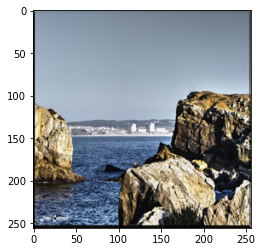

In [32]:
i = 4
plt.imshow(real_images[i].permute(1,2,0).cpu())

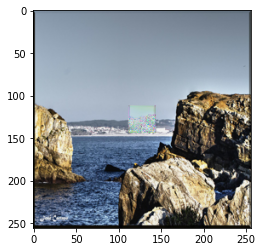

In [33]:
plt.imshow(masked_images[i].permute(1,2,0).cpu().detach().numpy())